<img src="https://www.ismiletechnologies.com/wp-content/uploads/2021/09/Feature-Engineering-in-machine-learning.png"
     width="1300" 
     height="200" />

Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. 


This is can be achieved through:


- **Feature Creation:** Creating features involves creating new variables which will be most helpful for our model. This can be adding or removing some features.
- **Transformations:** Feature transformation is simply a function that transforms features from one representation to another. The goal here is to plot and visualise data, if something is not adding up with the new features we can reduce the number of features used, speed up training, or increase the accuracy of a certain model.
- **Feature Extraction:** Feature extraction is the process of extracting features from a data set to identify useful information. Without distorting the original relationships or significant information, this compresses the amount of data into manageable quantities for algorithms to process.

In [0]:
# data manipulation  functions
from pyspark.sql.functions import *
import numpy as np
import pandas as pd

# visualisation
#import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
%matplotlib inline
#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [0]:
# spark session
spark = SparkSession.builder.appName('engineering').getOrCreate()

In [0]:
data_set = sqlContext.sql('SELECT * FROM lake_data')

In [0]:
new_data_set = data_set.na.drop()

In [0]:
new_data_set.show()

+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|      Date|Rainfall_S_Piero|Rainfall_Mangona|Rainfall_S_Agata|Rainfall_Cavallina|Rainfall_Le_Croci|Temperature_Le_Croci|Lake_Level|Flow_Rate|
+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|02/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                 6.5|    251.21|      0.5|
|03/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                4.45|    251.28|      0.5|
|04/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                 2.0|    251.35|      0.5|
|05/01/2004|             0.2|             0.0|             0.0|               0.0|              0.0|                 0.9|    251.37|      0.5|

In [0]:
new_data_set.count()

Out[74]: 6025

####Features from the date

The model will forecasts lake water availability in terms of level or water flow in a given time interval of the year. The time interval is defined as day/month depending on the time unit the model works on (for instance, for a model working on a monthly interval a forecast over the month is expected). Hence we need to engineer day, month and year features. This allows us to experiment with different intervals and use whichsover allows better predictability.

In [0]:
#Changing the date to correct datatype

data = new_data_set.withColumn('new_date',to_date("Date","dd/MM/yyyy"))

# new data frame with correct datatypes

df = data.select(['new_date',
 'Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate'])

# renaming date

df = df.withColumnRenamed('new_date','Date')

In [0]:
# Month
df_analysis = df.withColumn('Month', month(df['Date']))

# dayofmonth
df_analysis = df_analysis.withColumn('Day_of_Month', dayofmonth(df['Date']))

# week of the year
df_analysis = df_analysis.withColumn('Week_of_Year', weekofyear(df['Date']))

# year
df_analysis = df_analysis.withColumn('Year', year(df['Date']))

In [0]:
df_analysis.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Rainfall_S_Piero: double (nullable = true)
 |-- Rainfall_Mangona: double (nullable = true)
 |-- Rainfall_S_Agata: double (nullable = true)
 |-- Rainfall_Cavallina: double (nullable = true)
 |-- Rainfall_Le_Croci: double (nullable = true)
 |-- Temperature_Le_Croci: double (nullable = true)
 |-- Lake_Level: double (nullable = true)
 |-- Flow_Rate: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day_of_Month: integer (nullable = true)
 |-- Week_of_Year: integer (nullable = true)
 |-- Year: integer (nullable = true)



###Feature from Rainfall data

#### Data in daily intervals

In [0]:
# taking average of each rainfall column
df_1 = df_analysis.withColumn("mean_of_Rainfall", 
                    (col("Rainfall_S_Piero") + col("Rainfall_Mangona") + col('Rainfall_S_Agata') + col("Rainfall_Cavallina") + col("Rainfall_Le_Croci"))/5)


In [0]:
df_avg_day = df_1.select(['Day_of_Month','Week_of_Year','Month','Year','mean_of_Rainfall','Temperature_Le_Croci','Lake_Level','Flow_Rate'])

#### Data in weekly intervals

In [0]:
df_w = df_avg_day.groupBy(['year', 'Week_of_Year']).agg(avg("mean_of_Rainfall"), avg('Temperature_Le_Croci'),avg('Lake_Level'),avg('Flow_Rate'))
df_week = df_w.orderBy(['year','Week_of_Year'])

In [0]:
df_week.columns

Out[81]: ['year',
 'Week_of_Year',
 'avg(mean_of_Rainfall)',
 'avg(Temperature_Le_Croci)',
 'avg(Lake_Level)',
 'avg(Flow_Rate)']

In [0]:
# taking monthly average
df_avg_week = df_week.withColumnRenamed('avg(mean_of_Rainfall)','avg_Rainfall')

df_avg_week = df_avg_week.withColumnRenamed('avg(Temperature_Le_Croci)', 'avg_Temperature_Le_Croci')

df_avg_week = df_avg_week.withColumnRenamed('avg(Lake_Level)', 'avg_Lake_Level')

df_avg_week = df_avg_week.withColumnRenamed('avg(Flow_Rate)', 'avg_Flow_Rate')

####Data in Monthly intervals

In [0]:
df_2 = df_avg_day.groupBy(['year', 'month']).agg(avg("mean_of_Rainfall"), avg('Temperature_Le_Croci'),avg('Lake_Level'),avg('Flow_Rate'))
df_3 = df_2.orderBy(['year','month'])

In [0]:
# taking monthly average
df_avg_month = df_3.withColumnRenamed('avg(mean_of_Rainfall)','avg_Rainfall')

df_avg_month = df_avg_month.withColumnRenamed('avg(Temperature_Le_Croci)', 'avg_Temperature_Le_Croci')

df_avg_month = df_avg_month.withColumnRenamed('avg(Lake_Level)', 'avg_Lake_Level')

df_avg_month = df_avg_month.withColumnRenamed('avg(Flow_Rate)', 'avg_Flow_Rate')

In [0]:
df_avg_month.columns

Out[85]: ['year',
 'month',
 'avg_Rainfall',
 'avg_Temperature_Le_Croci',
 'avg_Lake_Level',
 'avg_Flow_Rate']

####Feature Scaling

If the data in any conditions has data points far from each other, scaling is a technique to make them closer to each other or in simpler words, we can say that the scaling is used for making data points generalized so that the distance between them will be lower.

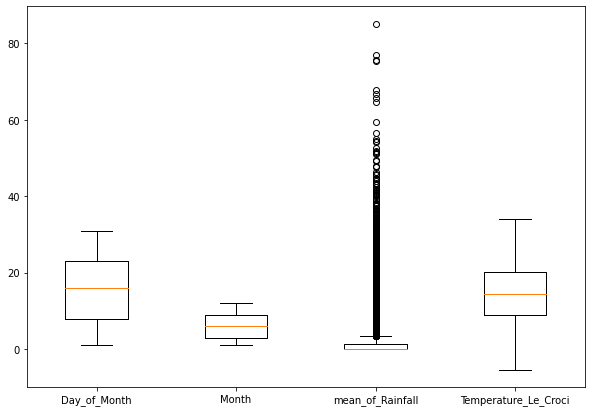

In [0]:
# box plot of unscaled data
df = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()
fig = plt.figure(figsize =(10, 7))
labels = df.columns
plt.boxplot(df)
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

The plot shows how different feature scales are.

####Normalization

This method rescales the data where we try to fit all the data points between the range of 0 to 1 so that the data points can become closer to each other. The 
Normalizer takes parameter p, which specifies the p-norm used for normalization. (p=2 by default.) This normalization can help standardize your input data and improve the behavior of learning algorithms.

#####Daily Average

In [0]:
# instantiate assembler
assembler = VectorAssembler(inputCols = ['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci'],
                           outputCol = 'features')
# transform data
df_avg_daily = assembler.transform(df_avg_day)  

# Normalize each Vector using L^1 norm.
normalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
df_l1Norm_Day = normalizer.transform(df_avg_daily)


# Normalize each Vector using $L^\infty$ norm.
df_lInfNorm_Day = normalizer.transform(df_avg_daily, {normalizer.p: float("inf")})

#####Weekly Average

In [0]:
df_avg_week.columns

Out[88]: ['year',
 'Week_of_Year',
 'avg_Rainfall',
 'avg_Temperature_Le_Croci',
 'avg_Lake_Level',
 'avg_Flow_Rate']

In [0]:
# instantiate assembler
assembler = VectorAssembler(inputCols = ['Week_of_Year','avg_Rainfall','avg_Temperature_Le_Croci'],
                           outputCol = 'features')
# transform data
df_avg_weekly = assembler.transform(df_avg_week)  

# Normalize each Vector using L^1 norm.
normalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
df_l1Norm_Week = normalizer.transform(df_avg_weekly)


# Normalize each Vector using $L^\infty$ norm.
df_lInfNorm_week = normalizer.transform(df_avg_weekly, {normalizer.p: float("inf")})

#####Monthly Average

In [0]:
# instantiate assembler
assembler = VectorAssembler(inputCols = ['month','avg_Rainfall','avg_Temperature_Le_Croci'],
                           outputCol = 'features')
# transform data
df_avg_monthly = assembler.transform(df_avg_month)  

# Normalize each Vector using L^1 norm.
normalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
df_l1Norm_Mon = normalizer.transform(df_avg_monthly)

# Normalize each Vector using $L^\infty$ norm.
df_lInfNorm_Mon = normalizer.transform(df_avg_monthly, {normalizer.p: float("inf")})

######Plot showing the effect of normalization in daily averaged data.

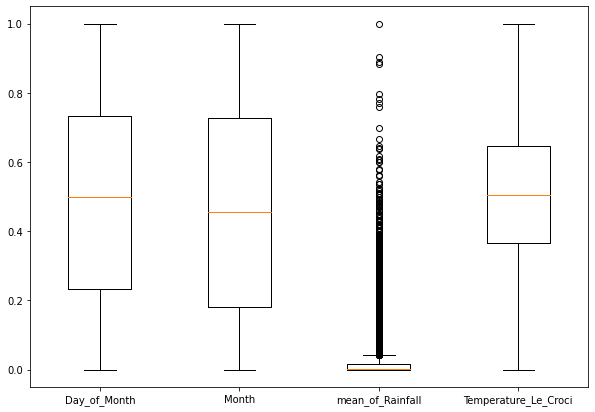

In [0]:
df_norm = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()
#Instantiate scaler
norm_scaler = MinMaxScaler()
#fit data
norm_scaler.fit(df_norm)
# create scaled version of the predictors
scaled_features = norm_scaler.transform(df_norm)
# convert the scaled predictor values into a dataframe
df_norm_scaled = pd.DataFrame(scaled_features,columns = df_norm.columns)
fig = plt.figure(figsize =(10, 7))
labels = df_norm_scaled.columns
plt.boxplot(df_norm_scaled)
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

The features have values between 0 and 1.

####Standardization

This method makes data points to be centred about the mean of all the data points presented in a feature with a unit standard deviation. This means the mean of the data point will be zero and the standard deviation will be 1.

#####Daily Average

In [0]:
# instantiate scaler 
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures",
                        withStd = True, withMean = False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_avg_daily)

# Normalize each feature to have unit standard deviation.
df_stnd_Day = scalerModel.transform(df_avg_daily)


#####Weekly Average

In [0]:
# instantiate scaler 
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures",
                        withStd = True, withMean = False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_avg_weekly)

# Normalize each feature to have unit standard deviation.
df_stnd_Week = scalerModel.transform(df_avg_weekly)

#####Monthly Average

In [0]:
 #instantiate scaler
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures",
                        withStd = True, withMean = False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_avg_monthly)

# Normalize each feature to have unit standard deviation.
df_stnd_Mon = scalerModel.transform(df_avg_monthly)

######Plot showing the effect of standardization in daily averaged data.

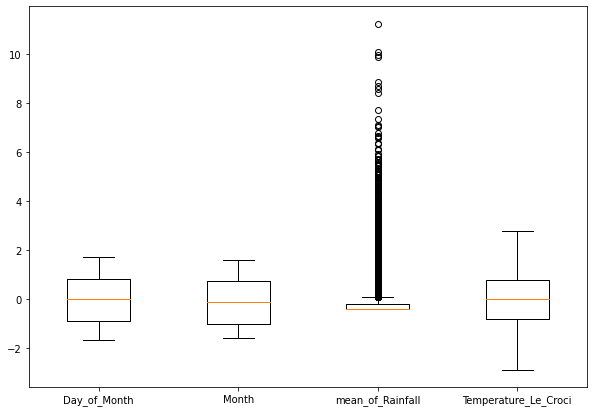

In [0]:
from sklearn.preprocessing import StandardScaler
df_stnd = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()
#instantiate a scale
stnd_scaler = StandardScaler()

#fit data
stnd_scaler.fit(df_stnd)

# create scaled version of the predictors
scaled_predictors = stnd_scaler.transform(df_stnd)
# convert the scaled predictor values into a dataframe
df_stnd_scaled = pd.DataFrame(scaled_predictors,columns = df_stnd.columns)

#Box plots of scaled data
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_stnd_scaled)
labels = df_norm_scaled.columns
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

The features are now centered around zero which is the new mean after standardization.

####Robust Scaler

RobustScaler transforms a dataset of Vector rows, removing the median and scaling the data according to a specific quantile range (by default the IQR: Interquartile Range, quantile range between the 1st quartile and the 3rd quartile). Its behavior is quite similar to StandardScaler, however the median and the quantile range are used instead of mean and standard deviation, which make it robust to outliers

#####Daily Average

In [0]:
#instantiate scaler
scaler = RobustScaler(inputCol = "features", outputCol = "scaledFeatures",
                      withScaling = True, withCentering = False,
                      lower = 0.25, upper = 0.75)

# Compute summary statistics by fitting the RobustScaler
scalerModel = scaler.fit(df_avg_daily)

# Transform each feature to have unit quantile range.
df_rbs_Day = scalerModel.transform(df_avg_daily)


#####Weekly Average

In [0]:
#instantiate scaler
scaler = RobustScaler(inputCol = "features", outputCol = "scaledFeatures",
                      withScaling = True, withCentering = False,
                      lower = 0.25, upper = 0.75)

# Compute summary statistics by fitting the RobustScaler
scalerModel = scaler.fit(df_avg_weekly)

# Transform each feature to have unit quantile range.
df_rbs_Day = scalerModel.transform(df_avg_weekly)

#####Monthly Average

In [0]:
#instantiate scaler
scaler = RobustScaler(inputCol = "features", outputCol = "scaledFeatures",
                      withScaling = True, withCentering = False,
                      lower = 0.25, upper = 0.75)

# Compute summary statistics by fitting the RobustScaler
scalerModel = scaler.fit(df_avg_monthly)

# Transform each feature to have unit quantile range.
df_rbs_Mon = scalerModel.transform(df_avg_monthly)

The increase in predictive accuracy is not guaranteed in any method of feature transformation, this would depend on the algorithm. Some ML algorithms perform better on some transformations, hence we focused on these 3 and we compare the predictive accuracy results to see which method is fit for our data set.

####Finding the Effect of Rainfall and Temperature

It is of the utmost importance to notice that some features like rainfall and temperature, which are present in each dataset, don’t go alongside the date. Indeed, both rainfall and temperature affect features like lake level and flow rate some time after it fell down. This means, for instance, that rain fell on 1st January doesn’t affect the mentioned features right the same day but some time later.

We try to find the number of days after which the temperature and rainfall affect lake level and flow rate.

####Daily interval
#####Lake_Level

In [0]:
# lake level
df_daily = df_avg_day
df_lake_level = df_daily.select('Lake_Level').toPandas()
lake_error = [] # 
lake_num_days = [] # number of days to shift by

#wildcard df
df_wildcard = df_daily.toPandas()

df_lake = df_daily.select('Lake_Level').toPandas()

for i in range(1,32): # looping through 31 days
    
    if i != 1:
        
        indice = len(df_lake_level)-i # i last index
        
        value = df_lake.iloc[indice:].values.tolist()
        
    else:
        indice = len(df_lake_level) #last index
        
        value = df_lake.iloc[-1].values.tolist()
    
    # last data before shifting down
    
    df_temp = df_lake_level.shift(periods = i, fill_value = 0) # reversing data
    
    for count in range(0,i):
        
        value = [ele for ele in reversed(value)]
        
        df_temp.iloc[count] = value[count]
    
    df_k = df_wildcard[['mean_of_Rainfall','Temperature_Le_Croci']] # rainfall and temp data
    
    df_c = df_temp[['Lake_Level']] #shifted lake level data
    
    df_appended = df_k.join(df_c, how = 'right') # temporary df for modeling
    
    # Pandas to Spark
    df_spark = spark.createDataFrame(df_appended)
    #=====================================assembler===========================================
    assembler = VectorAssembler(inputCols = ['mean_of_Rainfall','Temperature_Le_Croci'],
                                outputCol = 'features')
    df_model = assembler.transform(df_spark)
    
    train_data, test_data = df_model.randomSplit([0.6, 0.4])
    
    rf = RandomForestRegressor(featuresCol = "features", labelCol = 'Lake_Level', predictionCol = 'prediction')
    #    mae = df_spark.corr('mean_of_Rainfall','Lake_Level')

    # Train model.  This also runs the indexer.
    model = rf.fit(train_data)

    # Make predictions.
    predictions = model.transform(test_data)

    # compute test error
    evaluator = RegressionEvaluator(labelCol = "Lake_Level", predictionCol = "prediction", 
                                    metricName = "mae")
    
    mae = evaluator.evaluate(predictions)
    
    #================================appending================================================
    
    lake_error.append(mae)
    
    lake_num_days.append(i)
    
    df_lake_level = df_daily.select('Lake_Level').toPandas()
df_neee = pd.DataFrame({'days' : lake_num_days,
                       'mae': lake_error})

Out[136]: <AxesSubplot:xlabel='days', ylabel='mae'>

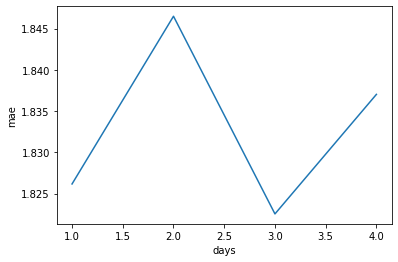

In [0]:
# plot error vs days
df_errorr = df_neee[df_neee['days'] < 5]

y_graph = df_errorr[['mae']] # y data
x_graph = df_errorr[['days']] # x data

sns.lineplot(data = df_errorr, x = "days", y = "mae")

#####Flow_Rate

In [0]:
# flow rate
df_flow_rate = df_daily.select('Flow_Rate').toPandas()
flow_error = [] # 
flow_num_days = [] # number of days to shift by

#wildcard df
df_wildcard = df_daily.toPandas()

df_flow = df_daily.select('Flow_Rate').toPandas()

for i in range(1,32): # looping through 31 days
    
    if i != 1:
        
        indice = len(df_flow_rate)-i # i last index
        
        value = df_flow.iloc[indice:].values.tolist()
        
    else:
        indice = len(df_flow_rate) #last index
        
        value = df_flow.iloc[-1].values.tolist()
    
    # last data before shifting down
    
    df_temp = df_flow_rate.shift(periods = i, fill_value = 0) # reversing data
    
    for count in range(0,i):
        
        value = [ele for ele in reversed(value)]
        
        df_temp.iloc[count] = value[count]
    
    df_k = df_wildcard[['mean_of_Rainfall','Temperature_Le_Croci']] # rainfall and temp data
    
    df_c = df_temp[['Flow_Rate']] #shifted lake level data
    
    df_appended = df_k.join(df_c, how = 'right') # temporary df for modeling
    
    # Pandas to Spark
    df_spark = spark.createDataFrame(df_appended)
    #=====================================assembler===========================================
    assembler = VectorAssembler(inputCols = ['mean_of_Rainfall','Temperature_Le_Croci'],
                                outputCol = 'features')
    df_model = assembler.transform(df_spark)
    
    train_data, test_data = df_model.randomSplit([0.6, 0.4])
    
    rf = RandomForestRegressor(featuresCol = "features", labelCol = 'Flow_Rate', predictionCol = 'prediction')
    #    mae = df_spark.corr('mean_of_Rainfall','Lake_Level')

    # Train model.  This also runs the indexer.
    model = rf.fit(train_data)

    # Make predictions.
    predictions = model.transform(test_data)

    # compute test error
    evaluator = RegressionEvaluator(labelCol = "Flow_Rate", predictionCol = "prediction", 
                                    metricName = "mae")
    
    mae = evaluator.evaluate(predictions)
    
    #================================appending================================================
    
    flow_error.append(mae)
    
    flow_num_days.append(i)
    
    df_flow_rate = df_daily.select('Flow_Rate').toPandas()
df_neee = pd.DataFrame({'days' : flow_num_days,
                       'mae': flow_error})

Out[140]: <AxesSubplot:xlabel='days', ylabel='mae'>

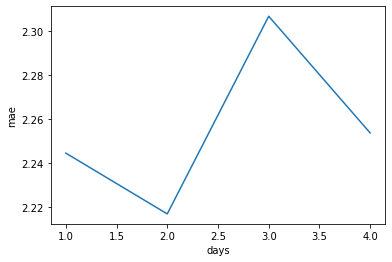

In [0]:

# plot error vs days
df_errorr = df_neee[df_neee['days'] < 5]

y_graph = df_errorr[['mae']] # y data
x_graph = df_errorr[['days']] # x data

sns.lineplot(data = df_errorr, x = "days", y = "mae")

####Weekly interval
#####Lake_Level